# Understanding tf.dataset and TFDS

This example started by asking chatGPT how to test the VGG16
Although there are many working examples in books, the goal was to see if the transformer would be able to generate a working example with all the subtetlies of data loading, resizing, and so on. Certainly chatGPT gave useful information but it was ambiguous with functions like "load_data()" that require more code.\

After asking several more questions to chatGPT and checking online and books, I put together this example that illustrates the use of tf.dataset, TFDS, data generators, lambda functions and transfer learning. 

Something to point out is that some information from GPT was wrong and required to research deeper. For example, it first created a loss with "categorical entropy" instead of "sparse_categorical_crosentropy" that was required for this case with the tf_flowers dataset.

Over all, getting the example from a book would have been easier but less educational. 


### tf.dataset objects
Start by creating tf.dataset wit tensors

In [1]:
import tensorflow as tf
X=tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

2023-01-12 08:45:26.718352: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 08:45:28.972557: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 08:45:30.326503: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10214 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:09:00.0, compute capability: 8.6
2023-01-12 08:45:

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [2]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [3]:
dataset = dataset.map(lambda x: x*2)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [4]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(18, shape=(), dtype=int32)


## Using TFDS (tensorflow dataset project)

Now let us load the mnist as a tf.dataset from the TFDS project

In [5]:
import tensorflow_datasets as tfds

In [6]:
dataset = tfds.load("mnist",as_supervised=True)
train_dataset, test_dataset = dataset["train"], dataset["test"]

In [7]:
for item in train_dataset.take(2):
    print(type(item))
    # this works when as_supervised=True
    images,labels=item
    # this works when as_supervised is False or the builder is used instead
    #images = item["image"]
    #labels = item["label"]
    print(type(images))

<class 'tuple'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tuple'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


2023-01-12 08:45:42.929676: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


The VGG16 takes inputs with (224x224) so a resizing would be needed.\
Here is where the use of map and lambda functions from the tf.dataset class starts to be handy.

In [8]:
import tensorflow as tf

# Define a function that resizes the data
def resize_data(x,y):
  x = tf.image.resize(x, (224, 224))
  return x, y 
# Apply the resize function to the dataset using map
resized_dataset = train_dataset.map(resize_data)


2023-01-12 08:45:46.451790: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


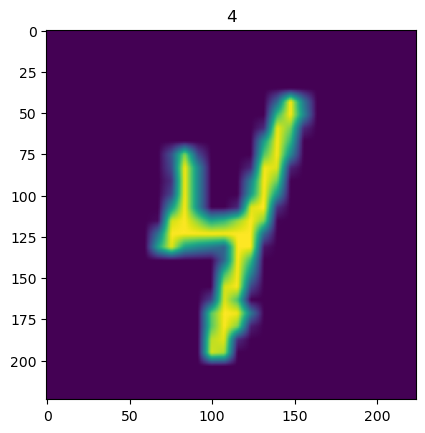

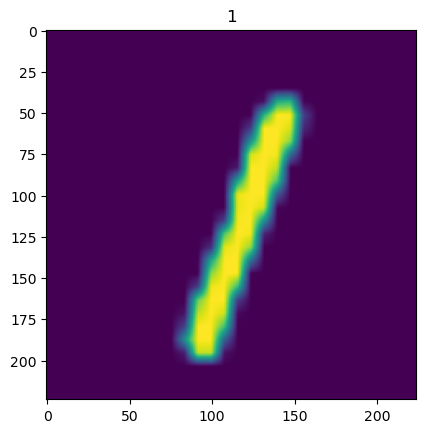

In [9]:
import matplotlib.pyplot as plt
import numpy as np
for item in resized_dataset.take(2):
    x,y=item
    plt.figure()
    plt.imshow(x),plt.title(np.array(y))

## Different data sets
Although mnist could be in principle a good test, the input for VGG16 requires 3 channels.
We could create other channels but to keep learning about TFDS let us try a different dataset

Let us try with the tf_flowers dataset that has only 5 classes but the images are color (3 channels), instead of the mnist that is 1 channel.


In [10]:
dataset = tfds.load("tf_flowers",as_supervised=True)
train_dataset = dataset["train"]
def resize_data(x,y):
  x = tf.image.resize(x, (224, 224))
  # Also let us scale it to go from 0-255 to 0-1
  x = x/255
  return x, y 
resized_dataset = train_dataset.map(resize_data)

(224, 224, 3)
1.0 0.0
(224, 224, 3)
0.9671116 0.0


2023-01-12 08:45:50.440669: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


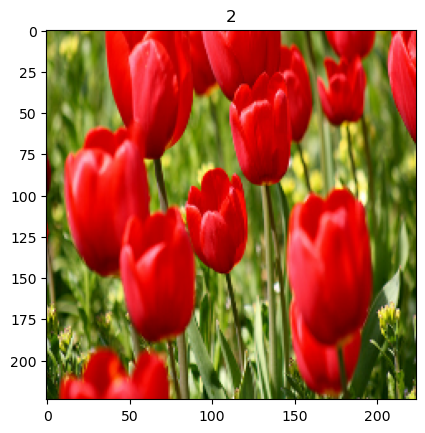

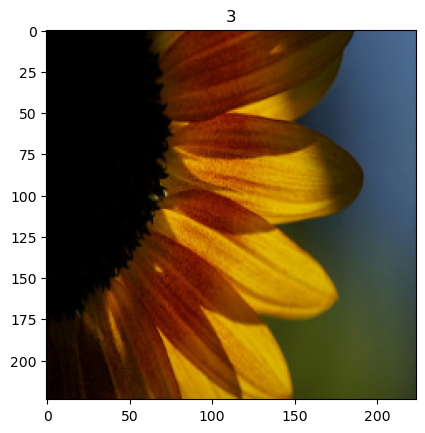

In [11]:
for item in resized_dataset.take(2):
    x,y=item
    print(x.shape)
    print(np.max(x),np.min(x))
    plt.figure()
    plt.imshow(x),plt.title(np.array(y))

This can be done with the tfds.builder but it does not take the as_supervised=True parameter
That forces us to use the 'image' 'label' keys.
Using the map function in the tf.dataset we can make the x,y tuple like shown below


In [12]:
import tensorflow_datasets as tfds

# Download the Imagenet dataset
imagenet_builder = tfds.builder("tf_flowers")
imagenet_builder.download_and_prepare()

# Load the Imagenet dataset as a `tf.data.Dataset` object
imagenet_dataset = imagenet_builder.as_dataset()


In [13]:
train_dataset = imagenet_dataset['train']

In [14]:
import tensorflow as tf
assert isinstance(train_dataset,tf.data.Dataset)

2023-01-12 08:45:57.111847: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Text(0.5, 1.0, '2')

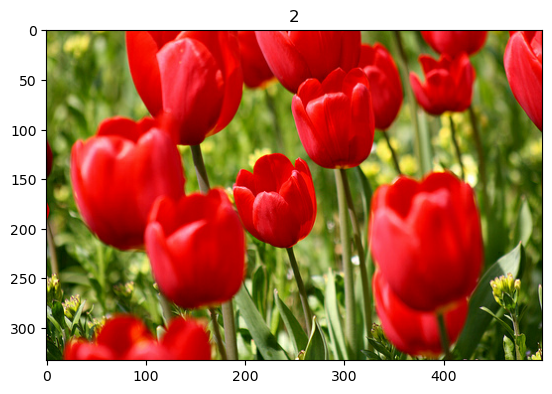

In [15]:
import matplotlib.pyplot as plt
x=train_dataset.take(1).as_numpy_iterator().next()
plt.imshow(x['image'])
plt.title(x['label'])


In [16]:
#Or using the map function
train_dataset = train_dataset.map(lambda item: (item['image'],item['label']))

In [17]:
resized_dataset = train_dataset.map(resize_data)

(224, 224, 3)
1.0 0.0
(224, 224, 3)
0.9671116 0.0


2023-01-12 08:46:01.686094: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


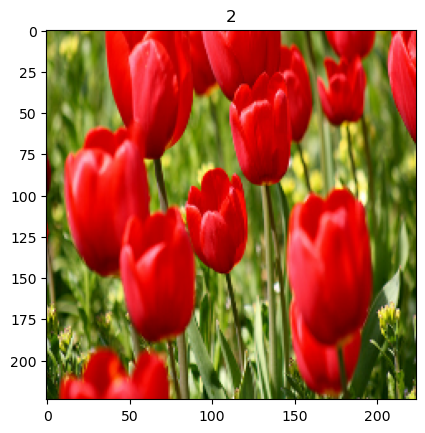

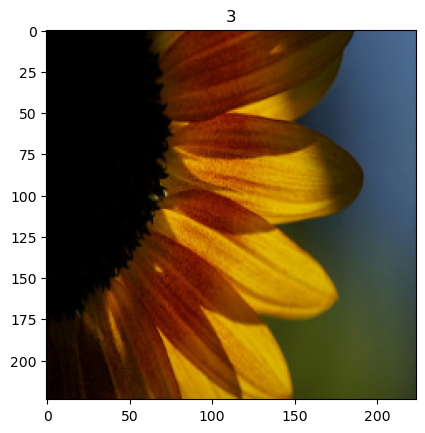

In [18]:
for item in resized_dataset.take(2):
    x,y=item
    print(x.shape)
    print(np.max(x),np.min(x))
    plt.figure()
    plt.imshow(x),plt.title(np.array(y))

In [19]:
from tensorflow.keras.applications import VGG16

# Load the VGG16 model with weights pre-trained on ImageNet
base_model = VGG16(weights='imagenet',include_top=False)
base_model.output.get_shape()

TensorShape([None, None, None, 512])

In [20]:
base_model.input.get_shape()

TensorShape([None, None, None, 3])

In [21]:
for layer in base_model.layers:
    layer.trainable = False

In [22]:
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(5, activation="softmax")(avg)
model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

In [23]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [24]:
model.output.get_shape()

TensorShape([None, 5])

In [25]:
#model.summary()

For now we will train everything but later we will freeze the base_model to use transfer learning.

In [26]:
train = resized_dataset.batch(32).prefetch(1)
# notice that the loss has to be "sparse_categorical_crossentropy" for this to work
history1=model.fit(train, epochs=10)

Epoch 1/10


2023-01-12 08:46:18.290808: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-01-12 08:46:23.216189: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-01-12 08:46:23.222823: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f5c9c19d8a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-12 08:46:23.222848: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-01-12 08:46:23.222857: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2023-01-12 08:46:23.228287: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-

115/115 [==============================] - 18s 89ms/step - loss: 1.3975 - accuracy: 0.4850
Epoch 2/10
115/115 [==============================] - 8s 72ms/step - loss: 1.0979 - accuracy: 0.6580
Epoch 3/10
115/115 [==============================] - 8s 73ms/step - loss: 0.9498 - accuracy: 0.6995
Epoch 4/10
115/115 [==============================] - 8s 73ms/step - loss: 0.8603 - accuracy: 0.7319
Epoch 5/10
115/115 [==============================] - 8s 73ms/step - loss: 0.7987 - accuracy: 0.7485
Epoch 6/10
115/115 [==============================] - 8s 73ms/step - loss: 0.7529 - accuracy: 0.7594
Epoch 7/10
115/115 [==============================] - 8s 73ms/step - loss: 0.7171 - accuracy: 0.7678
Epoch 8/10
115/115 [==============================] - 8s 73ms/step - loss: 0.6881 - accuracy: 0.7771
Epoch 9/10
115/115 [==============================] - 8s 73ms/step - loss: 0.6639 - accuracy: 0.7858
Epoch 10/10
115/115 [==============================] - 8s 73ms/step - loss: 0.6432 - accuracy: 0.7916

<AxesSubplot:>

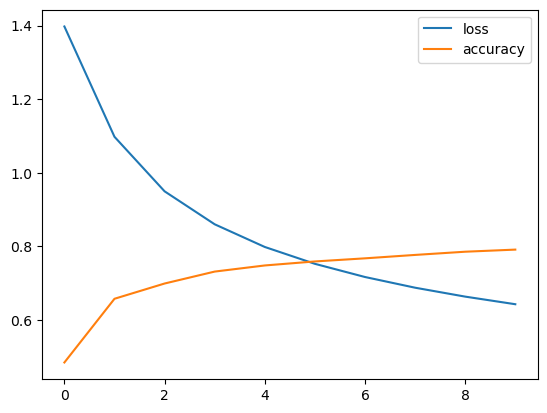

In [27]:
import pandas as pd
hist1=pd.DataFrame(history1.history)
hist1.plot()

In [28]:
model.evaluate(train.take(100))

100/100 [==============================] - 8s 72ms/step - loss: 0.6387 - accuracy: 0.7959


[0.6386803984642029, 0.7959374785423279]

In [29]:
yy=np.arange(10,dtype=int)
print(yy)
print(np.argmax(yy))

[0 1 2 3 4 5 6 7 8 9]
9


In [30]:
for item in resized_dataset.batch(32).take(2):
    x,y=item
    print(x.shape)
    print(y.shape)
    print(y)
    ypred=model.predict(x)
    print(ypred.shape)
    print(np.argmax(ypred,axis=-1))


(32, 224, 224, 3)
(32,)
tf.Tensor([2 3 3 4 3 0 0 0 0 1 3 2 4 1 2 1 1 2 3 3 3 0 3 2 1 1 1 3 4 2 2 3], shape=(32,), dtype=int64)
1/1 [==============================] - 0s 243ms/step
(32, 5)
[2 4 3 4 3 0 0 0 0 1 3 0 4 1 2 1 1 4 3 3 2 0 4 2 1 1 0 3 4 2 2 3]
(32, 224, 224, 3)
(32,)
tf.Tensor([2 4 2 2 0 0 0 2 0 3 0 1 1 1 2 1 3 4 4 0 0 2 3 2 2 3 4 4 1 4 2 2], shape=(32,), dtype=int64)
1/1 [==============================] - 0s 44ms/step
(32, 5)
[3 4 4 2 0 0 0 2 0 3 2 1 4 1 2 1 3 4 4 0 0 4 0 2 4 0 4 4 1 4 2 2]


One more thing to try is to convert the tf.dataset into a data generator.
This is based on direct code from GPT but it needed editing.

In [31]:
# Create a dataset that produces batches of data
batch_size = 32
dataset = resized_dataset.batch(batch_size).repeat()

In [32]:
# Create an iterator from the dataset
iterator = dataset.__iter__()


In [33]:
batch = iterator.get_next()
type(batch)

tuple

In [34]:
def generator():
  while True:
    try:
      # Get the next batch of data from the iterator
      batch = iterator.get_next()
      # Extract the input and output elements from the batch
      x, y = batch
      x=tf.image.resize(x,(224,224))
      yield (x, y)
    except tf.errors.OutOfRangeError:
      print("data exhausted")
      # Reset the iterator when the dataset is exhausted (did not work)
      # iterator.reset() 

In [36]:
# Use the generator as the input to model.fit, There is a problem problem as before.
history2=model.fit(generator(), epochs=10, steps_per_epoch=len(resized_dataset) // batch_size)


Epoch 1/10
114/114 [==============================] - 9s 75ms/step - loss: 0.5188 - accuracy: 0.8318
Epoch 2/10
114/114 [==============================] - 9s 75ms/step - loss: 0.5130 - accuracy: 0.8351
Epoch 3/10
114/114 [==============================] - 9s 75ms/step - loss: 0.5061 - accuracy: 0.8364
Epoch 4/10
114/114 [==============================] - 9s 75ms/step - loss: 0.4983 - accuracy: 0.8392
Epoch 5/10
114/114 [==============================] - 9s 76ms/step - loss: 0.4932 - accuracy: 0.8411
Epoch 6/10
114/114 [==============================] - 9s 75ms/step - loss: 0.4879 - accuracy: 0.8436
Epoch 7/10
114/114 [==============================] - 9s 75ms/step - loss: 0.4812 - accuracy: 0.8458
Epoch 8/10
114/114 [==============================] - 9s 76ms/step - loss: 0.4777 - accuracy: 0.8472
Epoch 9/10
114/114 [==============================] - 9s 75ms/step - loss: 0.4720 - accuracy: 0.8491
Epoch 10/10
114/114 [==============================] - 9s 75ms/step - loss: 0.4685 - accura

<AxesSubplot:>

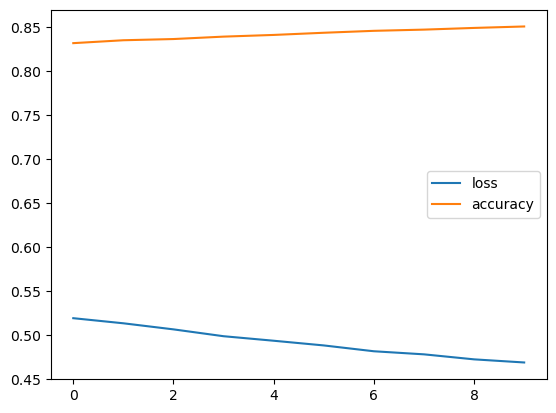

In [37]:
import pandas as pd
hist2=pd.DataFrame(history2.history)
hist2.plot()

# Comparing with VGG16 implemented from Scratch (without transfer learning)
From Andrew Ferlitsch, 2021. Deep Learning Patterns and Practices

In [38]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import GlobalAveragePooling2D

def conv_block(n_layers, n_filters):
    for n in range(n_layers):
        model2.add(Conv2D(n_filters, (3,3), strides=(1,1), padding="same", activation="relu"))
    model2.add(MaxPooling2D(2, strides=2))

model2 = Sequential()
model2.add(Conv2D(64, (3,3), strides=(1,1), padding="same", activation="relu", input_shape=(224,224,3)))
conv_block(1, 64)
conv_block(2, 128)
conv_block(3, 256)
conv_block(3, 512)
conv_block(3, 512)
model2.add(Flatten())
model2.add(Dense(4096, activation="relu"))
model2.add(Dense(4096, activation="relu"))
# here let us make the changes to output 5 classes only
# original  model2.add(Dense(1000, activation="softmax"))
# new (problem when adding this layer below)
#model2.add(GlobalAveragePooling2D())
model2.add(Dense(5, activation="softmax"))

# original model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model2.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


In [39]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [40]:
history3=model2.fit(generator(), epochs=10, steps_per_epoch=len(resized_dataset) // batch_size)

Epoch 1/10
114/114 [==============================] - 49s 297ms/step - loss: 1.7775 - accuracy: 0.2339
Epoch 2/10
114/114 [==============================] - 28s 249ms/step - loss: 1.6023 - accuracy: 0.2449
Epoch 3/10
114/114 [==============================] - 28s 250ms/step - loss: 1.6015 - accuracy: 0.2460
Epoch 4/10
114/114 [==============================] - 28s 250ms/step - loss: 1.6016 - accuracy: 0.2446
Epoch 5/10
114/114 [==============================] - 28s 249ms/step - loss: 1.6015 - accuracy: 0.2446
Epoch 6/10
114/114 [==============================] - 28s 250ms/step - loss: 1.6018 - accuracy: 0.2438
Epoch 7/10
114/114 [==============================] - 29s 250ms/step - loss: 1.6016 - accuracy: 0.2441
Epoch 8/10
114/114 [==============================] - 28s 250ms/step - loss: 1.6015 - accuracy: 0.2449
Epoch 9/10
114/114 [==============================] - 28s 250ms/step - loss: 1.6013 - accuracy: 0.2446
Epoch 10/10
114/114 [==============================] - 28s 250ms/step - l

<AxesSubplot:>

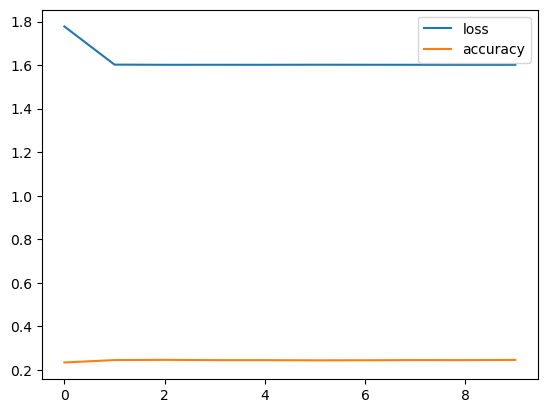

In [41]:
import pandas as pd
hist3=pd.DataFrame(history3.history)
hist3.plot()